In [277]:
#Importing necessary modules
import pandas as pd
import numpy as np
from datetime import date
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns 

### Builidng the target variable 

In [288]:
#Reading in the csv files that contains information about time of login
user_engagement = pd.read_csv('takehome_user_engagement.csv')
#Converting time stamp to datetime isocalendar object of the format (year,week number,day)
def conv(s):
    dt =  datetime.strptime(s,'%Y-%m-%d %H:%M:%S')
    return datetime.isocalendar(dt)[0:2]
user_engagement.loc[:,'time_stamp'] = user_engagement.time_stamp.apply(conv)
#Grouping each user by number of logins in each week they were active
first_group = user_engagement.groupby(['user_id','time_stamp'])
first_group = first_group['visited'].count()
df_weeks = pd.DataFrame(first_group)
#Extracting the week the user logged in the most number of times of all the weeks they've been active
user_target = df_weeks.max(level=0)
user_target = user_target.reset_index()
#Building the target variable based on wether the maximum number of logins during the week are less than 3
def build_target(n):
    if n >= 3:
        return 1
    else:
        return 0
user_target.loc[:,'visited'] = user_target.visited.apply(build_target)
user_target.columns = ['user_id','retained']
#Displaying the constructed target variable column 'retained' and respective user_id column
user_target.head(5)

,user_id,retained
0,1,0
1,2,1
2,3,0
3,4,0
4,5,0


### Extracting the total number of weeks a user has been active to be used as a feature column

In [206]:
df_weeks_count = df_weeks.reset_index()
df_weeks_count = df_weeks_count.drop(['visited'],axis=1)
df_weeks_count = df_weeks_count.groupby('user_id')
df_weeks_count = df_weeks_count['time_stamp'].count()
df_weeks_count = pd.DataFrame(df_weeks_count)
df_weeks_count = df_weeks_count.reset_index()
df_weeks_count.columns = ['user_id','weeks_active']
df_weeks_count.head()

,user_id,weeks_active
0,1,1
1,2,11
2,3,1
3,4,1
4,5,1


### Reading in and feature engineering on the predictor variables 

In [235]:
users_info = pd.read_csv('takehome_users.csv',encoding='latin-1')
users_info.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


#### Feature engineered columns
 - total_logins - Total number of times each user has logged in to the application
 - weeks_active - Total number of weeks a user has been active on the platform by logging in 
 - account_at_last_login - Wether the user already had an account during their last login or they signed up after their last login

In [236]:
#Merging the target variable and features on their respective user id's
df = pd.merge(users_info,user_target,how='inner',left_on='object_id',right_on='user_id')
df = df.drop(['invited_by_user_id'],axis=1)
#Building the total logins column for each user
total_logs = pd.DataFrame(user_engagement['user_id'].value_counts())
total_logs = total_logs.reset_index()
total_logs.columns = ['user_id','total_logins']
#joining total logins with the main dataframe containing all features
df = pd.merge(df,total_logs,how='inner',left_on='object_id',right_on='user_id')
df = pd.merge(df,df_weeks_count,how='inner',left_on='object_id',right_on='user_id')
df = df.drop(['user_id','user_id_x','user_id_y','org_id'],axis=1)
#Converting the unix time stamp column 'last_session_creation_time' to a datetime column
def from_unix(n):
    dt = datetime.fromtimestamp(n).strftime('%Y-%m-%d %H:%M:%S')
    return datetime.strptime(dt,'%Y-%m-%d %H:%M:%S')
df.loc[:,'last_session_creation_time'] = df.last_session_creation_time.apply(from_unix)
#Converting the time stamp column 'creation time' to datetime object
def from_time_stamp(n):
    return datetime.strptime(n,'%Y-%m-%d %H:%M:%S')
df.loc[:,'creation_time'] = df.creation_time.apply(from_time_stamp)
#Comapring the above built datetime columns to create the 'account_at_last_login' column
def account_created(row):
    if row['creation_time'] > row['last_session_creation_time']:
        return 'created after'
    else:
        return 'existing user'
df['account_at_last_login'] = df.apply(lambda row:account_created(row),axis=1)
#Dropping columns that would not contribute value to model accuracy for machine learning
df = df.drop(['creation_time','name','email','last_session_creation_time'],axis=1)
df.head()

,object_id,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,retained,total_logins,weeks_active,account_at_last_login
0,1,GUEST_INVITE,1,0,0,1,1,created after
1,2,ORG_INVITE,0,0,1,14,11,existing user
2,3,ORG_INVITE,0,0,0,1,1,created after
3,4,GUEST_INVITE,0,0,0,1,1,existing user
4,5,GUEST_INVITE,0,0,0,1,1,existing user


#### One Hot Encoding categorical variables

In [269]:
df_ml = pd.get_dummies(df,drop_first=True)
#Dropping redundant column 'object_id'
df_ml = df_ml.drop(['object_id'],axis=1)
df_ml.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,retained,total_logins,weeks_active,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,account_at_last_login_existing user
0,1,0,0,1,1,0,0,0,0,0
1,0,0,1,14,11,1,0,0,0,1
2,0,0,0,1,1,1,0,0,0,0
3,0,0,0,1,1,0,0,0,0,1
4,0,0,0,1,1,0,0,0,0,1


### Machine learning and feature importances

In [270]:
#Importing necessary modules
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
X = np.array(df_ml.drop(['retained'],axis=1))
y = np.array(df_ml['retained'])
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
from pandas_ml import ConfusionMatrix
%matplotlib inline
#ML helper function
def display_stats(model,name):
    print()
    print('-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*')
    print()
    print('Accuracy on unseen hold out set:',model.score(X_test,y_test)*100,'%')
    print()
    y_pred = model.predict(X_test)
    y_pred_s = pd.Series(y_pred).replace([0,1],['not_retained','retained'])
    y_test_s = pd.Series(y_test).replace([0,1],['not_retained','retained'])
    confusion_matrix = ConfusionMatrix(y_test_s,y_pred_s)
    confusion_matrix.plot(normalized=True,backend='seaborn')
    plt.title('Confusion Matrix For '+str(name))
    plt.show()
    print("Binary confusion matrix:\n%s" %confusion_matrix)
    print()
    print('Positive = retained')
    print('Negative = not_retained')
    print()
    print('True Positive Rate:',confusion_matrix.TPR * 100,'%')
    print('False Positive Rate:',confusion_matrix.FPR * 100,'%')
    print('True Negative Rate:',confusion_matrix.TNR * 100,'%')
    print('False Negative Rate:',confusion_matrix.FNR * 100,'%')

### Random Forest Classifier
Random forest classifier fits several weak decision trees on the data using bootsrap aggregating and averages out the predictions from all the decision trees to classify an observation
 - Random forest is a collinearity robust algorithim 
 - Works well on datasets with non-standardized features , with different ranges
 - Allows us to specify class_weights which greatly helps to give a balanced result in case of imbalanced classes like ours

In [271]:
#Tuning 'min_samples_leaf' and 'min_samples_split' using 5 fold cross validation
rf = RandomForestClassifier(n_estimators=100,n_jobs=-1,max_features='sqrt',random_state=42,class_weight={0:.1,1:1})
param_grid1 = {"min_samples_split": np.arange(2, 11),
              "min_samples_leaf": np.arange(1,10)}
rf_cv = GridSearchCV(rf,param_grid1,cv=5,n_jobs=-1)
rf_cv.fit(X_train,y_train)
print(rf_cv.best_params_)
print(rf_cv.best_score_)

{'min_samples_leaf': 1, 'min_samples_split': 5}
0.98554831397


In [266]:
#Tuning 'max_depth' using 5 fold cross validation 
rf = RandomForestClassifier(n_estimators=100,n_jobs=-1,max_features='sqrt',random_state=42,
                            min_samples_split=5,min_samples_leaf=1,class_weight = {0:.1,1:1})
param_grid2 ={'max_depth':np.arange(10,28)}
rf_cv = GridSearchCV(rf,param_grid2,cv=5,n_jobs=-1)
rf_cv.fit(X_train,y_train)
print(rf_cv.best_params_)
print(rf_cv.best_score_)

{'max_depth': 14}
0.985689997166


#### Increasing the number of estimators and fitting on hold out set

Training Accuracy: 99.2065741003 %

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

Accuracy on unseen hold out set: 98.0736543909 %



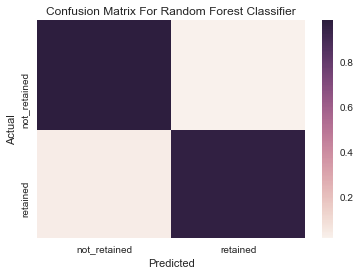

Binary confusion matrix:
Predicted     not_retained  retained  __all__
Actual                                       
not_retained          1436        24     1460
retained                10       295      305
__all__               1446       319     1765

Positive = retained
Negative = not_retained

True Positive Rate: 96.7213114754 %
False Positive Rate: 1.64383561644 %
True Negative Rate: 98.3561643836 %
False Negative Rate: 3.27868852459 %


In [273]:
rf = RandomForestClassifier(n_estimators=300,n_jobs=-1,max_features='sqrt',random_state=42,
                            min_samples_split=5,min_samples_leaf=1,max_depth=14,class_weight={0:.1,1:1})
rf.fit(X_train,y_train)
print('Training Accuracy:',rf.score(X_train,y_train)*100,'%')
display_stats(rf,'Random Forest Classifier')

**Observation:** The model is not overfitted and generalized extremely well. On the unseen hold out set had an **overall accuracy of 98.07%.** The **True Positive Rate (correctly indentified a retained user)** and the **True Negative Rate (correctly identified a non retained user)** are **96.72% and 98.35% respectively.** The **False Positive Rate (incorrectly labelled a non-retained user as retained)** and the **False Negative Rate (incorrectly labelled a retained user as non retained) are 1.64% and 3.27% respectively.**

#### Feature Importances as identifed by the random forest classifier

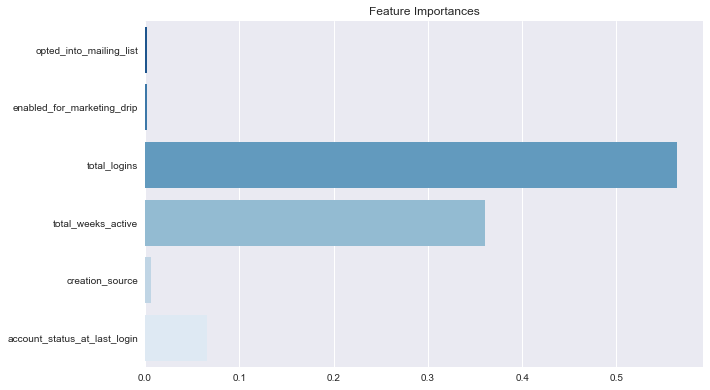

In [286]:
#Extracting assigned feature importances as assigned by the random forest classifier and adaboost classifier
def calc_fimps(m:'fitted model')->'numpy array':
    f_imp = np.append(m.feature_importances_[:4],sum(m.feature_importances_[4:8]))
    return np.append(f_imp,m.feature_importances_[8])
f_imps = calc_fimps(rf)
features = ['opted_into_mailing_list','enabled_for_marketing_drip','total_logins','total_weeks_active',
            'creation_source','account_status_at_last_login']
f, ax = plt.subplots(figsize=(10,14))
plt.subplot(2,1,1)
sns.barplot(x=f_imps,y=features,palette=sns.color_palette("Blues_r"))
plt.title('Feature Importances')

plt.show()

**Observation:** The intrinsic dimensionality of the data is 2 dimensional centred around the metric total_logins which is the total number of times each user has been active(logged in) on the platform follwed by the metric 'weeks_active' which is the metric that indenitfies the span of time each user has been using the platform measured in weeks. These are the features identified by the random forest classifier as the strongest predictors of wether a user will be retained or not